In [1]:
import glob
import numpy as np
import plotly.graph_objects as go
import pandas as pd
from scipy import signal

In [2]:
def filter_data(com):
    #smoothen COM
    com_smooth = signal.savgol_filter(com, 
                                     30, 
                                     3, 
                                     axis = 0)
    return(com_smooth)

In [3]:
def compute_frenet_serret(points):
    """
    Compute Frenet-Serret frames (Tangent, Normal, Binormal vectors)
    for a discrete 3D curve given by points (Nx3 numpy array).
    Handles uneven point spacing.
    written by ChatGPT, adapted by Tanvi Deora, April 2025
    """
    points = np.asarray(points)
    n = len(points)
    
    # Compute arc length increments ds between points
    diffs = np.diff(points, axis=0)
    seg_lengths = np.linalg.norm(diffs, axis=1) # get length of each segments
    ds = signal.savgol_filter(seg_lengths, 50,3) # smoothen the ds
    ds = np.concatenate(([seg_lengths[0]], ds))  # Assume forward diff at first point
    ds = (ds[:-1] + ds[1:]) / 2  # Average spacing for centered difference
    
    # First derivative d(r)/ds => Tangent
    dp = points[1:]/ds[:, np.newaxis]
    T = dp / np.linalg.norm(dp, axis=1)[:, np.newaxis]

    # Derivative of Tangent: dT/ds
    dT = T /ds[:, np.newaxis]
    norm_dT = np.linalg.norm(dT, axis=1) # this is the k = curvature in T = kN
    N = np.zeros_like(dT)
    nonzero = norm_dT > 1e-8
    N[nonzero] = dT[nonzero] / norm_dT[nonzero][:, np.newaxis]

    # Binormal: B = T x N
    B = np.cross(T, N)

    return ds, dp, T, norm_dT, N, B

In [4]:
def make_fig_kappa_single(fig, k, com):
    if len(k) != len(com):
        print('check lengths of kappa and com')
    else:
        fig.add_trace(go.Scatter3d(x = com[:,0]
             , y = com[:,1]
             , z = com[:,2]
             , mode = 'markers'
             , marker = dict(size=4, color=k, colorscale = 'jet'
                                   ,colorbar=dict(title='k value')  # Add colorbar with title
                                   )))

In [5]:
def make_fig_kappa(k_chaser, com_chaser, k_chasee, com_chasee, title_text):
    import plotly.graph_objects as go
    from plotly.subplots import make_subplots

    color_min = np.min([k_chaser, k_chasee])
    color_max = np.max([k_chaser, k_chasee])
    
    
    # Create the subplot figure
    fig = make_subplots(
        rows=2, cols=2,
        specs=[[{"type": "scene", "rowspan": 2}, {"type": "xy"}],
               [None, {"type": "xy"}]]
        ,subplot_titles=("Chasee (small)- Chaser (large)", "Chasee Kappa", "Chaser Kappa")
    )
    
    #Chasee
    # Add 3D scatter plot
    fig.add_trace(go.Scatter3d(
        x = com_chasee[:,0]
        , y = com_chasee[:,1]
        , z = com_chasee[:,2]
        , mode = 'markers'
        , marker = dict(size=2
                        ,color=k_chasee
                        ,colorscale = 'jet'
                        ,cmin = color_min
                        ,cmax = color_max
                        ,colorbar=dict(title='k value')# Add colorbar with title
                        ))
        ,row=1, col=1
    )

    # Add 2D line plot
    fig.add_trace(
        go.Scatter(x=np.arange(len(k_chasee)), y=k_chasee, mode='lines'),
        row=1, col=2
    )
    
    # Chaser
    # Add 3D scatter plot
    fig.add_trace(go.Scatter3d(
        x = com_chaser[:,0]
        , y = com_chaser[:,1]
        , z = com_chaser[:,2]
        , mode = 'markers'
        , marker = dict(size=4
                        ,color=k_chaser
                        ,colorscale = 'jet'
                        ,cmin = color_min
                        ,cmax = color_max
                        ,colorbar=dict(title='k value')  # Add colorbar with title
                        ))
        ,row=1, col=1
    )

    # Add 2D line plot
    fig.add_trace(
        go.Scatter(x=np.arange(len(k_chaser)), y=k_chaser, mode='lines'),
        row=2, col=2
    )
    fig.update_layout(title_text=title_text)
    return(fig)

## Sanity Check with Spriral Data

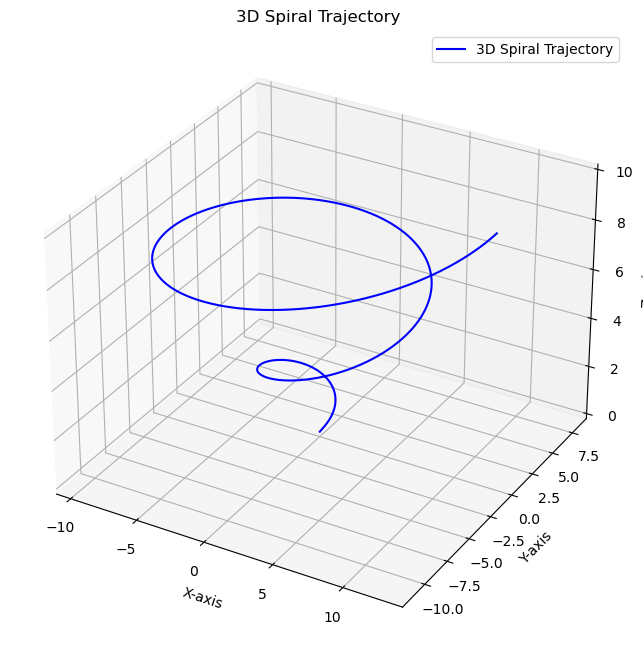

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Parameters
n_points = 10000  # Number of points
theta_max = 4 * np.pi  # Maximum angle (4 turns)

# Generate theta values
theta = np.linspace(0, theta_max, n_points)

# Generate the spiral in polar coordinates
r = theta  # Radius increases linearly with theta

# Convert polar to Cartesian coordinates (x, y)
x = r * np.cos(theta)
y = r * np.sin(theta)

# Define the z-coordinate (for 3D spiral)
z = np.linspace(0, 10, n_points)  # z increases linearly

# Plot the 3D spiral trajectory
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')

# Plot the spiral
ax.plot(x, y, z, label="3D Spiral Trajectory", color="blue")

# Labels and title
ax.set_title("3D Spiral Trajectory")
ax.set_xlabel("X-axis")
ax.set_ylabel("Y-axis")
ax.set_zlabel("Z-axis")

# Show grid and legend
ax.grid(True)
ax.legend()

plt.show()

In [7]:
points = np.transpose([x, y, z])
ds, dp, t, k, n, b = compute_frenet_serret(points)

In [8]:
fig = go.Figure()
make_fig_kappa_single(fig, k, points[1:])
fig.show()

## Run it on Real Data

In [34]:
COM_files = glob.glob('./Data/Outputs/Sampled_1k/COM/*_smoothened_*COM.csv')
COM_files

['./Data/Outputs/Sampled_1k/COM\\2023-04-19_Trial7_Set1_5k_smoothened_interpol_COM.csv',
 './Data/Outputs/Sampled_1k/COM\\2023-04-21_Trial6_1k_smoothened_interpol_COM.csv',
 './Data/Outputs/Sampled_1k/COM\\2023-04-21_Trial7_1k_smoothened_interpol_COM.csv',
 './Data/Outputs/Sampled_1k/COM\\2023-04-28_Trial4_5k_smoothened_interpol_COM.csv',
 './Data/Outputs/Sampled_1k/COM\\2023-04-28_Trial5_5k_smoothened_interpol_COM.csv',
 './Data/Outputs/Sampled_1k/COM\\2023-04-28_Trial8_1k_smoothened_interpol_COM.csv']

In [42]:
info = pd.read_csv('./Data/Outputs/Raw_xyz_points/metadata.csv')

In [47]:
for f in COM_files:
    name = f.split('\\')[-1][:-4]
    print(name)
    df = pd.read_csv(f)
    
    chasee_ID = [row['Chasee'] for ind, row in info.iterrows() if row['filename'][:-10] in f.split('\\')[-1]][0]
    chaser_ID = [row['Chaser'] for ind, row in info.iterrows() if row['filename'][:-10] in f.split('\\')[-1]][0] 
    
    chasee_haltere = chasee_ID.split('_')[0]
    chaser_haltere = chaser_ID.split('_')[0]

    chasee_com = df.loc[:,['chasee_com_x', 'chasee_com_y', 'chasee_com_z']].values
    chaser_com = df.loc[:,['chaser_com_x', 'chaser_com_y', 'chaser_com_z']].values
    
    chasee_com_smooth = filter_data(chasee_com)
    ds_ce, dp_ce, t_ce, k_ce, n_ce, b_ce = compute_frenet_serret(chasee_com_smooth)
    
    chaser_com_smooth = filter_data(chaser_com)
    ds_cr, dp_cr, t_cr, k_cr, n_cr, b_cr = compute_frenet_serret(chaser_com_smooth)
    
    title_text = "Chasee: " + str(chasee_ID) + '- Chaser: ' + str(chaser_ID)
    
#     fig = go.Figure()
    fig = make_fig_kappa(k_cr, chaser_com_smooth[1:], k_ce, chasee_com_smooth[1:], title_text)
    fig.write_html('./Data/Sampled1K_Figures/Curvature/' + name + '_kappa.html')
    fig.show()

2023-04-19_Trial7_Set1_5k_smoothened_interpol_COM


2023-04-21_Trial6_1k_smoothened_interpol_COM


2023-04-21_Trial7_1k_smoothened_interpol_COM


2023-04-28_Trial4_5k_smoothened_interpol_COM


2023-04-28_Trial5_5k_smoothened_interpol_COM


2023-04-28_Trial8_1k_smoothened_interpol_COM
